In [1]:
import os
import numpy as np
import h5py
import pandas as pd
import concurrent.futures
import scipy.io as sio
from tifffile import imread
import matplotlib.pyplot as plt

# Check current backend
print(f"Current backend: {plt.get_backend()}")

# If running in Jupyter or IPython, ensure inline plotting
%matplotlib inline

Current backend: module://matplotlib_inline.backend_inline


In [2]:
# Load parameters.csv to get scan information and metadata
csv_path = '/root/capsule/data/iGluSnFR_simulations_default_12/parameters.csv'  # Path to your parameters.csv
params_df = pd.read_csv(csv_path)

# Create a dictionary to map SimDescription (e.g., 1, 2, 3) to their corresponding metadata
metadata_dict = {}
for _, row in params_df.iterrows():
    sim_description = str(row['SimDescription'])  # Ensure it's a string for matching folder names like '1', '2', etc.
    metadata_dict[sim_description] = {
        'motionAmp': row['motionAmp'],
        'brightness': row['brightness'],
        'nsites': row['nsites'],
        'scan': row['scan']
    }

In [3]:
# Function to process each .mat file and extract motionC and motionR along with metadata
def process_mat_file(mat_file_path, sim_description):
    try:
        # Load the .mat file
        mat_contents = sio.loadmat(mat_file_path)

        # Assuming the structured array is stored under 'aData'
        data_key = 'aData'  # Adjust this if the key is different

        # Access the structured array
        structured_array = mat_contents[data_key]

        # Extract motionC and motionR
        motionC = structured_array['motionC'][0, 0].ravel()
        motionR = structured_array['motionR'][0, 0].ravel()
        
        # Retrieve metadata for this SimDescription (folder name)
        metadata = metadata_dict.get(sim_description, {})
        
        return (sim_description, motionC, motionR, metadata)
    except Exception as e:
        print(f"Error reading {mat_file_path}: {e}")
        return (sim_description, None, None, {})

In [4]:
# Function to process each .h5 file and extract MotionC and MotionR along with metadata
def process_h5_file(h5_file_path, sim_description, model_name):
    try:
        with h5py.File(h5_file_path, 'r') as h5_file:
            # Check for MotionC at different levels
            if 'MotionC' in h5_file.keys():
                motion_c_data = h5_file['MotionC'][:]
            elif 'C' in h5_file.keys():
                motion_c_data = h5_file['C'][:]
            elif 'aData/motionC' in h5_file:
                motion_c_data = h5_file['aData/motionC'][:]  # Check for aData/motionC
            else:
                motion_c_data = None

            # Check for MotionR at different levels
            if 'MotionR' in h5_file.keys():
                motion_r_data = h5_file['MotionR'][:]
            elif 'R' in h5_file.keys():
                motion_r_data = h5_file['R'][:]
            elif 'aData/motionR' in h5_file:
                motion_r_data = h5_file['aData/motionR'][:]  # Check for aData/motionR
            else:
                motion_r_data = None

            # Retrieve metadata for this SimDescription (folder name)
            metadata = metadata_dict.get(sim_description, {})
            
            return (sim_description, motion_c_data, motion_r_data, metadata, model_name)
    except Exception as e:
        print(f"Error reading {h5_file_path}: {e}")
        return (sim_description, None, None, {}, model_name)

# Load alignment data

In [5]:
h5_file_path = '/root/capsule/data/iGluSnFR_simulations_default_12_registered9/suite2p/1/SIMULATION_scan_00001-1_Trial1.h5'
sim_description = 1
model_name = 'suite2p'
_, MotionC_suite2p, MotionR_suite2p, _, _  = process_h5_file('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/suite2p/1/SIMULATION_scan_00001-1_Trial1.h5', sim_description, model_name)
_, MotionC_caiman, MotionR_caiman, _, _  = process_h5_file('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/caiman_stripCaiman/1/SIMULATION_scan_00001-1_Trial1.h5', sim_description, model_name)
_, MotionC_matlab, MotionR_matlab, _  = process_mat_file('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/stripRegisteration_matlab/1/SIMULATION_scan_00001-1_Trial1_ALIGNMENTDATA.mat', sim_description)

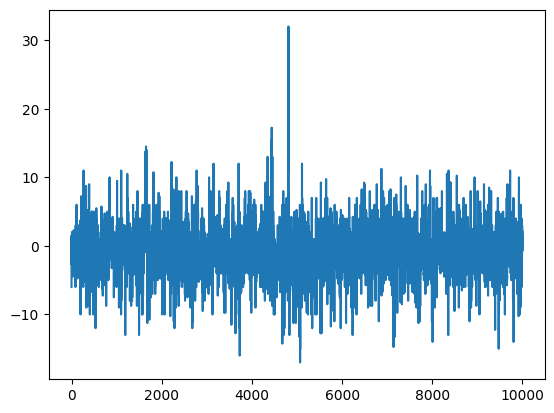

In [6]:
plt.plot(MotionC_matlab)

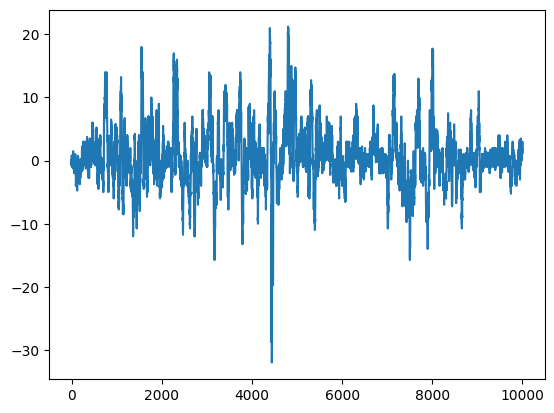

In [19]:
plt.plot(MotionR_matlab)

# Calculate the top 5 percentile of motion

In [30]:
motion_total_suite2p = np.sqrt((abs(MotionC_suite2p)/128)**2 + (abs(MotionR_suite2p)/50)**2)
motion_total_caiman = np.sqrt((abs(MotionC_caiman)/128)**2 + (abs(MotionR_caiman)/50)**2)
motion_total_matlab = np.sqrt((abs(MotionC_matlab)/128)**2 + (abs(MotionR_matlab)/50)**2)

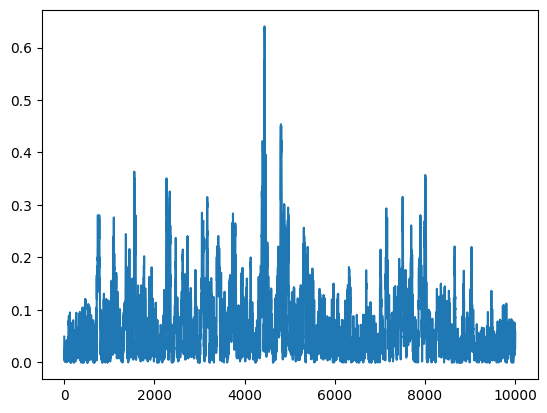

In [31]:
plt.plot(motion_total_matlab)

In [ ]:
# Calculate the 95th percentile for each variable
top_5_percentile_suite2p = np.percentile(motion_total_suite2p, 95)
top_5_percentile_caiman = np.percentile(motion_total_caiman, 95)
top_5_percentile_matlab = np.percentile(motion_total_matlab, 95)

# Extract values above or equal to the 95th percentile
top_5_values_suite2p = motion_total_suite2p[motion_total_suite2p >= top_5_percentile_suite2p]
top_5_indices_suite2p = np.where(motion_total_suite2p >= top_5_percentile_suite2p)[0]

top_5_values_caiman = motion_total_caiman[motion_total_caiman >= top_5_percentile_caiman]
top_5_indices_caiman = np.where(motion_total_caiman >= top_5_percentile_caiman)[0]

top_5_values_matlab = motion_total_matlab[motion_total_matlab >= top_5_percentile_matlab]
top_5_indices_matlab = np.where(motion_total_matlab >= top_5_percentile_matlab)[0]

#TODO: MX: unique of cat of top_5_percentile_indices_suite2p, top_5_percentile_indices_caiman, top_5_percentile_indices_matlab. 

# Combine all indices into one array
all_indices = np.concatenate([top_5_indices_suite2p, top_5_indices_caiman, top_5_indices_matlab])

# Find unique indices and their counts
unique_indices, counts = np.unique(all_indices, return_counts=True)

# Find the most common indices
max_count = np.max(counts)
most_common_indices = unique_indices[counts == max_count]
print("Most common indices:", most_common_indices)

Most common indices: [ 739  740  741  742  743  744  745  746  747  748  749  750  766  768
  769  771  772  773  774  775  776  777  778  779  780 1096 1097 1098
 1099 1364 1365 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560
 1561 1562 1563 1564 1565 1566 1567 1568 1570 1572 1575 1576 1577 1578
 1579 1580 1581 1582 1583 2259 2260 2261 2262 2263 2264 2265 2266 2267
 2268 2269 2270 2271 2272 2273 2274 2275 2276 2277 2278 2279 2280 2281
 2282 2283 2284 2285 2286 2287 2288 2328 2329 2331 2332 2333 2335 2336
 2337 2338 2339 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349 2350
 2471 2472 2731 2732 2734 3052 3053 3054 3055 3056 3068 3069 3070 3071
 3072 3073 3076 3078 3079 3080 3081 3082 3083 3085 3159 3161 3162 3163
 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177
 3178 3179 3411 3412 3413 3414 3415 3739 3741 3742 3743 3744 3745 3746
 3747 3750 3752 3753 3784 3785 3786 3788 3789 3790 3791 3792 3793 4375
 4376 4377 4378 4379 4380 4381 4382 4383 4384 4385 4386 

In [33]:
most_common_indices.shape

(411,)

In [29]:
top_5_percentile_suite2p

np.float64(2.0)

In [13]:
top_5_percentile_indices.shape

(543,)

# Load registered movie and based on index of top percentage get those frames

In [35]:
movie_suite2p = imread('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/suite2p/1/SIMULATION_scan_00001-1_Trial1.tif')
movie_matlab = imread('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/stripRegisteration_matlab/1/SIMULATION_scan_00001-1_Trial1_REGISTERED_DOWNSAMPLED-1x.tif')
movie_caiman = imread('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/caiman_stripCaiman/1/SIMULATION_scan_00001-1_Trial1.tif')

In [36]:
# movie_top_motion = movie[top_5_percentile_indices, :,:]
# movie_top_motion_mean = np.nanmean(movie_top_motion, axis=0) 

In [46]:
movie_top_motion_suite2p = movie_suite2p[most_common_indices, :,:]
movie_top_motion_mean_suite2p = np.nanmean(movie_top_motion_suite2p, axis=0) 

movie_top_motion_caiman = movie_caiman[most_common_indices, :,:]
movie_top_motion_mean_caiman = np.nanmean(movie_top_motion_caiman, axis=0) 

movie_top_motion_matlab = movie_matlab[most_common_indices, :,:]
movie_top_motion_mean_matlab = np.nanmean(movie_top_motion_matlab, axis=0) 

/tmp/ipykernel_3366/115580955.py:8: RuntimeWarning: Mean of empty slice
  movie_top_motion_mean_matlab = np.nanmean(movie_top_motion_matlab, axis=0)


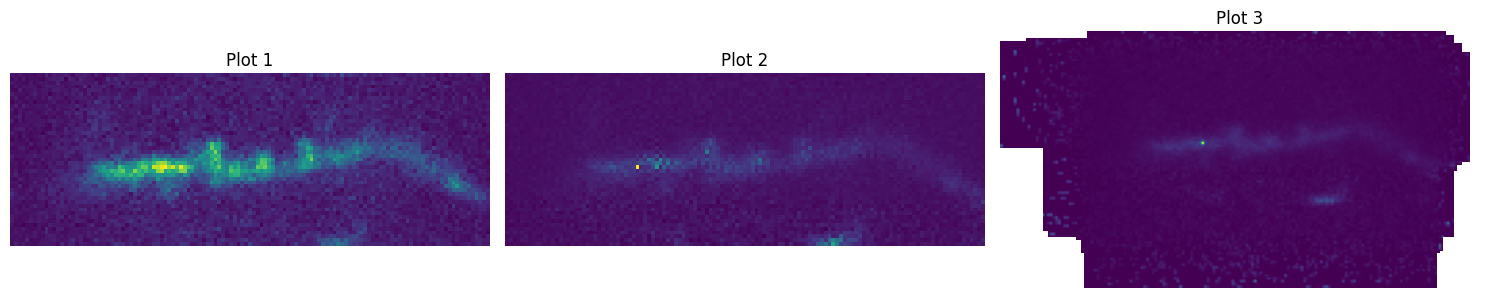

In [47]:
# Replace this with your actual data
movie_top_motion_mean_plot = [movie_top_motion_mean_suite2p, movie_top_motion_mean_caiman, movie_top_motion_mean_matlab]  # Replace with your 2D arrays

# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each image in a separate subplot
for i, ax in enumerate(axes):
    ax.imshow(movie_top_motion_mean_plot[i], cmap='viridis')  # Adjust colormap if needed
    ax.set_title(f"Plot {i+1}")
    ax.axis('off')  # Hide axes for better visualization

# Display the figure
plt.tight_layout()
plt.show()

In [22]:
movie_top_motion_mean.shape

(45, 125)

# Calculate correlation of mean of frames with most motion and every frame of the movie with most motion

# Suite2p

Suite2p: Correlation Calculation Complete:
Mean correlation: 0.14845947615634036
Median correlation: 0.1527765021812305
Min correlation: 0.006583316891266711
Max correlation: 0.23696298629510332
Standard deviation of correlations: 0.03615744456405579


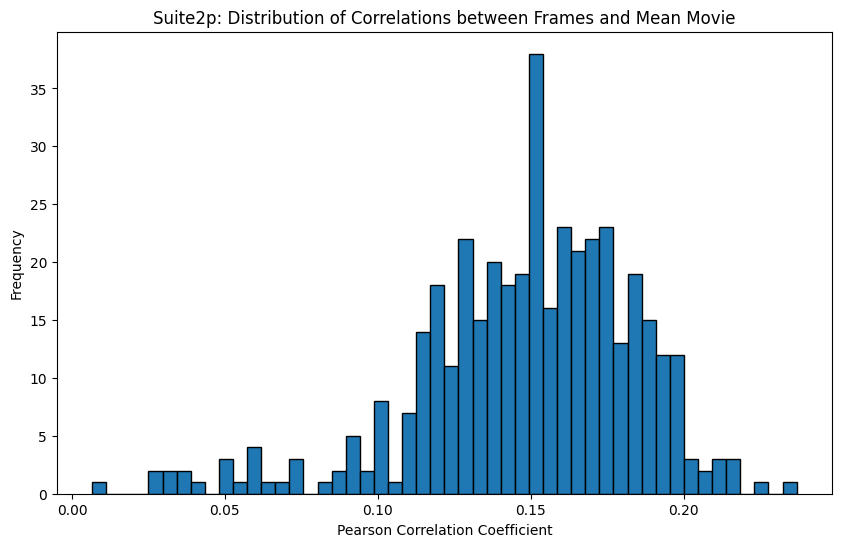

In [51]:
from scipy.stats import pearsonr

movie_top_motion_suite2p = np.nan_to_num(movie_top_motion_suite2p, nan=0.0)
movie_mean_suite2p = np.nanmean(movie_suite2p, axis=0)
movie_mean_suite2p = np.nan_to_num(movie_mean_suite2p, nan=0.0)

# Flatten the mean movie for correlation calculation
mean_movie_flat_suite2p = movie_mean_suite2p.flatten()

# Initialize an array to store correlations
correlations_suite2p = np.zeros(movie_top_motion_suite2p.shape[0])

# Calculate correlation for each frame
for i in range(movie_top_motion_suite2p.shape[0]):
    frame_flat_suite2p= movie_top_motion_suite2p[i].flatten()  # Flatten the current frame
    correlations_suite2p[i], _ = pearsonr(frame_flat_suite2p, mean_movie_flat_suite2p)  # Pearson correlation

# Output basic statistics of correlations
print("Suite2p: Correlation Calculation Complete:")
print("Mean correlation:", np.mean(correlations_suite2p))
print("Median correlation:", np.median(correlations_suite2p))
print("Min correlation:", np.min(correlations_suite2p))
print("Max correlation:", np.max(correlations_suite2p))
print("Standard deviation of correlations:", np.std(correlations_suite2p))

# Optional: Visualize correlation distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(correlations_suite2p, bins=50, edgecolor='black')
plt.title('Suite2p: Distribution of Correlations between Frames and Mean Movie')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [53]:
print('Suite2p: Mean of correlations:', np.mean(correlations_suite2p))

Suite2p: Mean of correlations: 0.14845947615634036


# Caiman

caiman: Correlation Calculation Complete:
Mean correlation: 0.18085944833563586
Median correlation: 0.18232254991015107
Min correlation: -0.003247512310831091
Max correlation: 0.3191203310318791
Standard deviation of correlations: 0.040865309255873276


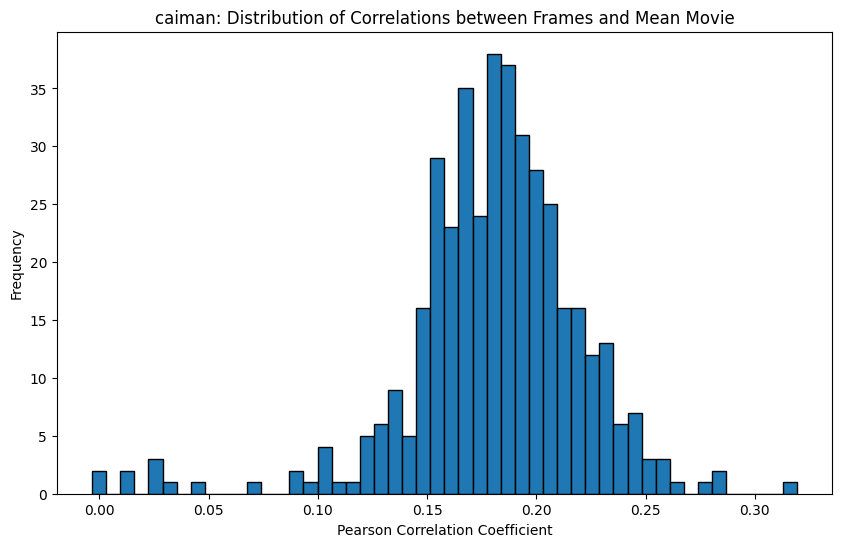

In [54]:
from scipy.stats import pearsonr

movie_top_motion_caiman = np.nan_to_num(movie_top_motion_caiman, nan=0.0)
movie_mean_caiman = np.nanmean(movie_caiman, axis=0)
movie_mean_caiman = np.nan_to_num(movie_mean_caiman, nan=0.0)

# Flatten the mean movie for correlation calculation
mean_movie_flat_caiman = movie_mean_caiman.flatten()

# Initialize an array to store correlations
correlations_caiman = np.zeros(movie_top_motion_caiman.shape[0])

# Calculate correlation for each frame
for i in range(movie_top_motion_caiman.shape[0]):
    frame_flat_caiman= movie_top_motion_caiman[i].flatten()  # Flatten the current frame
    correlations_caiman[i], _ = pearsonr(frame_flat_caiman, mean_movie_flat_caiman)  # Pearson correlation

# Output basic statistics of correlations
print("caiman: Correlation Calculation Complete:")
print("Mean correlation:", np.mean(correlations_caiman))
print("Median correlation:", np.median(correlations_caiman))
print("Min correlation:", np.min(correlations_caiman))
print("Max correlation:", np.max(correlations_caiman))
print("Standard deviation of correlations:", np.std(correlations_caiman))

# Optional: Visualize correlation distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(correlations_caiman, bins=50, edgecolor='black')
plt.title('caiman: Distribution of Correlations between Frames and Mean Movie')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [55]:
print('caiman: Mean of correlations:', np.mean(correlations_caiman))

caiman: Mean of correlations: 0.18085944833563586


# Matlab Strip

/tmp/ipykernel_3366/2506753663.py:4: RuntimeWarning: Mean of empty slice
  movie_mean_matlab = np.nanmean(movie_matlab, axis=0)


matlab: Correlation Calculation Complete:
Mean correlation: 0.18154338710250154
Median correlation: 0.18075789955522184
Min correlation: 0.05185896713514365
Max correlation: 0.31313071454768837
Standard deviation of correlations: 0.04243659449025547


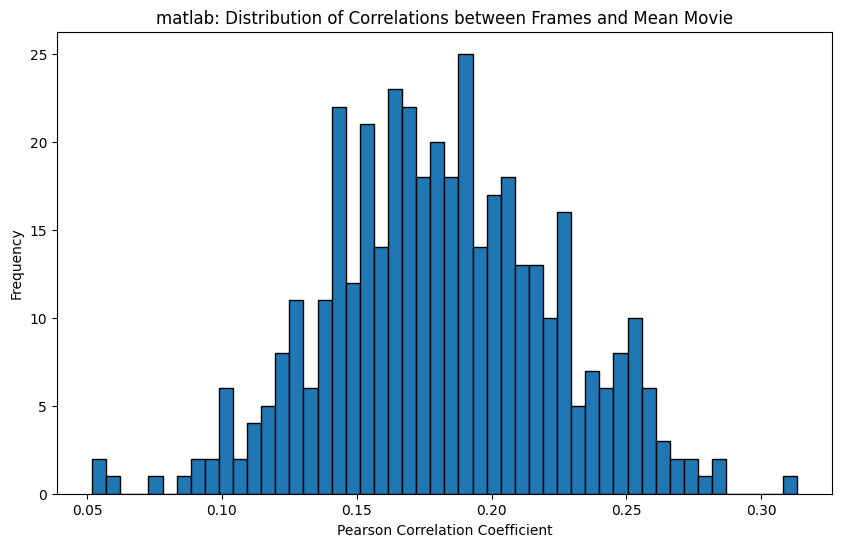

In [56]:
from scipy.stats import pearsonr

movie_top_motion_matlab = np.nan_to_num(movie_top_motion_matlab, nan=0.0)
movie_mean_matlab = np.nanmean(movie_matlab, axis=0)
movie_mean_matlab = np.nan_to_num(movie_mean_matlab, nan=0.0)

# Flatten the mean movie for correlation calculation
mean_movie_flat_matlab = movie_mean_matlab.flatten()

# Initialize an array to store correlations
correlations_matlab = np.zeros(movie_top_motion_matlab.shape[0])

# Calculate correlation for each frame
for i in range(movie_top_motion_matlab.shape[0]):
    frame_flat_matlab= movie_top_motion_matlab[i].flatten()  # Flatten the current frame
    correlations_matlab[i], _ = pearsonr(frame_flat_matlab, mean_movie_flat_matlab)  # Pearson correlation

# Output basic statistics of correlations
print("matlab: Correlation Calculation Complete:")
print("Mean correlation:", np.mean(correlations_matlab))
print("Median correlation:", np.median(correlations_matlab))
print("Min correlation:", np.min(correlations_matlab))
print("Max correlation:", np.max(correlations_matlab))
print("Standard deviation of correlations:", np.std(correlations_matlab))

# Optional: Visualize correlation distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(correlations_matlab, bins=50, edgecolor='black')
plt.title('matlab: Distribution of Correlations between Frames and Mean Movie')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [57]:
print('caiman: Mean of correlations:', np.mean(correlations_matlab))

caiman: Mean of correlations: 0.18154338710250154


# If we use indivijual frames from the movie

/tmp/ipykernel_641/3306622770.py:6: RuntimeWarning: Mean of empty slice
  movie_mean = np.nanmean(movie, axis=0)


Correlation Calculation Complete:
Mean correlation: 0.3647374124389803
Median correlation: 0.3659436356857858
Min correlation: 0.13438035504569212
Max correlation: 0.5885615912663325
Standard deviation of correlations: 0.06627507854705836


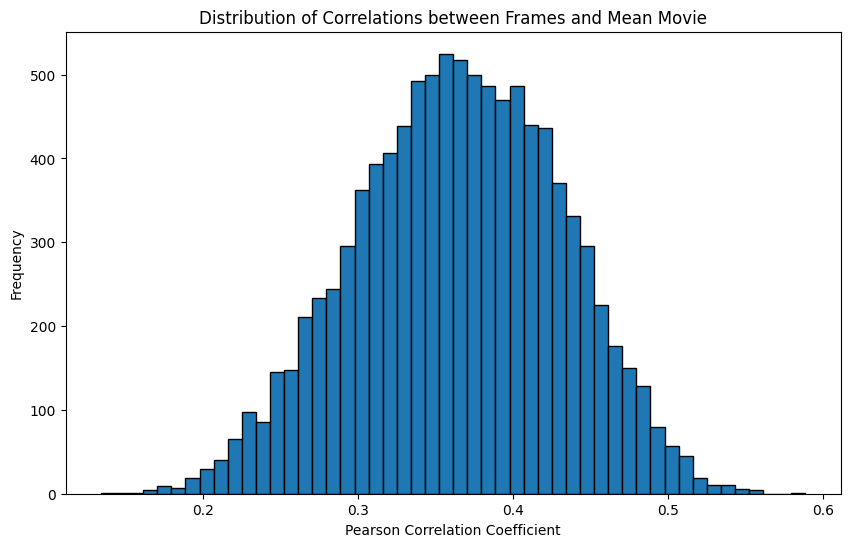

In [ ]:
# Plot a histogram of the correlations

from scipy.stats import pearsonr

movie_most_motion = np.nan_to_num(movie, nan=0.0)
movie_mean = np.nanmean(movie, axis=0)
mean_movie = np.nan_to_num(movie_mean, nan=0.0)

# Flatten the mean movie for correlation calculation
mean_movie_flat = mean_movie.flatten()

# Initialize an array to store correlations
correlations = np.zeros(movie_most_motion.shape[0])

# Calculate correlation for each frame
for i in range(movie_most_motion.shape[0]):
    frame_flat = movie_most_motion[i].flatten()  # Flatten the current frame
    correlations[i], _ = pearsonr(frame_flat, mean_movie_flat)  # Pearson correlation

# Output basic statistics of correlations
print("Correlation Calculation Complete:")
print("Mean correlation:", np.mean(correlations))
print("Median correlation:", np.median(correlations))
print("Min correlation:", np.min(correlations))
print("Max correlation:", np.max(correlations))
print("Standard deviation of correlations:", np.std(correlations))

plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=50, edgecolor='black')
plt.title('Distribution of Correlations between Frames and Mean Movie')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()
